In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from outil import *

In [2]:
# init data
env_test = small_loop(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1],
                [1, 0, 1, 0, 1],
                [1, 0, 0, 0, 1],
                [1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []

for i in range(50):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)

print(actions)
print(outcomes)

tokenizer = SimpleTokenizerV1(vocab=
        create_dico_numerate_word(env_test.get_outcomes() + env_test.get_actions()))

data_set = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)

data_loader_train = DataLoader(data_set, batch_size=16, shuffle=True, num_workers=4, drop_last=True)

# text, target = next(iter(data_loader_train))
# print(text)
# print(target)


for i in range(1000):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)

data_set_test = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)

data_loader_test = DataLoader(data_set, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

['turn_left', 'forward', 'turn_right', 'feel_front', 'turn_left', 'forward', 'turn_left', 'forward', 'turn_left', 'forward', 'feel_front', 'turn_right', 'turn_left', 'turn_right', 'turn_left', 'turn_left', 'feel_front', 'forward', 'turn_right', 'turn_left', 'turn_right', 'turn_left', 'turn_right', 'feel_front', 'forward', 'turn_right', 'turn_left', 'forward', 'forward', 'forward', 'turn_right', 'forward', 'turn_left', 'feel_front', 'turn_left', 'turn_left', 'forward', 'forward', 'turn_left', 'turn_right', 'feel_front', 'turn_right', 'turn_left', 'forward', 'feel_front', 'forward', 'feel_front', 'feel_front', 'turn_right', 'feel_front']
['empty', 'wall', 'empty', 'wall', 'empty', 'wall', 'empty', 'empty', 'empty', 'wall', 'wall', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'wall', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty', 'wall', 'wall', 'empty', 'empty', 'wall

In [3]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)

tensor([[ 0.2789, -0.7319,  0.0122, -1.5599,  0.8532],
        [-1.3934, -0.9126,  0.9651, -1.3196, -0.0812],
        [-0.2510, -0.3027,  1.3247, -0.5386, -1.2510]], requires_grad=True)
tensor([1, 4, 0])


Inspired by https://github.com/LukeDitria/pytorch_tutorials.git

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out

In [5]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
device = "cpu"

# Define the size of the hidden layer and number of LSTM layers
hidden_size = 64
num_layers = 1
len_vocab = len(env_test.get_outcomes() + env_test.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                       num_layers=num_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam optimizer
optimizer = optim.Adam(lstm_classifier.parameters(), lr=0.01)

# Define the loss function as CrossEntropyLoss for classification
loss_fn = nn.CrossEntropyLoss()

# Initialize lists to store training and test loss, as well as accuracy
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [6]:
# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(100):    
    # Set model to training mode
    lstm_classifier.train()
    steps = 0
    train_acc = 0
    
    # Iterate through training data loader
    for text, label in data_loader_train:
        bs = label.shape[0]
        

        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Forward pass through the model
        pred, hidden, memory = lstm_classifier(text, hidden, memory)

        # Calculate the loss
        loss = loss_fn(pred[:, -1, :], label)
            
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append training loss to logger
        training_loss_logger.append(loss.item())
        
        # Calculate training accuracy
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
        
    # Calculate and append training accuracy for the epoch
    print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
    train_acc = train_acc / steps
    training_acc_logger.append(train_acc)
    
    # Set model to evaluation mode
    lstm_classifier.eval()
    steps = 0
    
    # Iterate through test data loader
    with torch.no_grad():
        for text, label in data_loader_test:
            bs = label.shape[0]

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate test accuracy
            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        # Calculate and append test accuracy for the epoch
        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)

acc : 0.1875 / 3 / 16 for epoch 0
acc : 0.5 / 16 / 32 for epoch 0
acc : 0.6041666865348816 / 29 / 48 for epoch 0
acc : 0.59375 / 38 / 64 for epoch 0
acc : 0.625 / 50 / 80 for epoch 0
acc : 0.6458333134651184 / 62 / 96 for epoch 0
acc : 0.6607142686843872 / 74 / 112 for epoch 0
acc : 0.6796875 / 87 / 128 for epoch 0
acc : 0.6805555820465088 / 98 / 144 for epoch 0
acc : 0.6937500238418579 / 111 / 160 for epoch 0
acc : 0.7159090638160706 / 126 / 176 for epoch 0
acc : 0.7239583134651184 / 139 / 192 for epoch 0
acc : 0.745192289352417 / 155 / 208 for epoch 0
acc : 0.7544642686843872 / 169 / 224 for epoch 0
acc : 0.7666666507720947 / 184 / 240 for epoch 0
acc : 0.76171875 / 195 / 256 for epoch 0
acc : 0.7683823704719543 / 209 / 272 for epoch 0
acc : 0.7777777910232544 / 224 / 288 for epoch 0
acc : 0.7828947305679321 / 238 / 304 for epoch 0
acc : 0.7875000238418579 / 252 / 320 for epoch 0
acc : 0.7827380895614624 / 263 / 336 for epoch 0
acc : 0.7840909361839294 / 276 / 352 for epoch 0
acc : 0

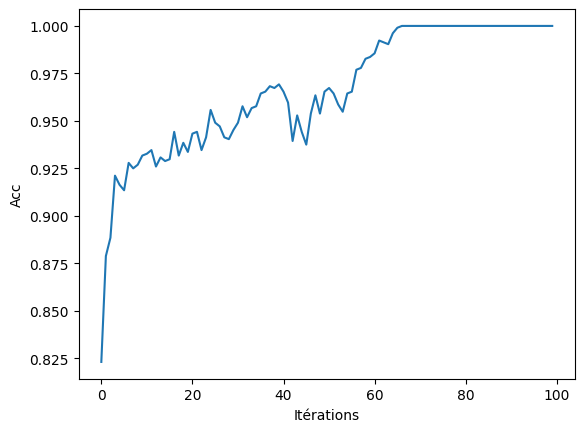

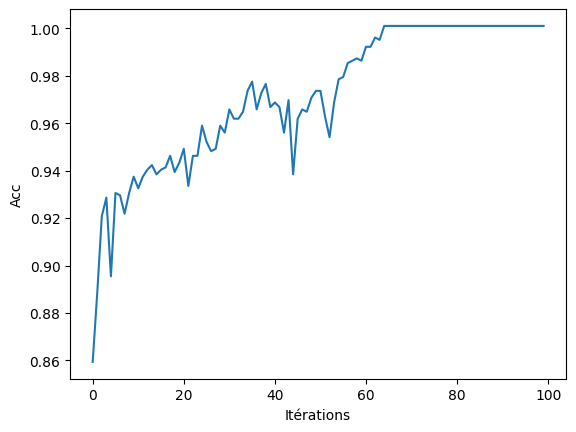

In [7]:
see_evolued_acc(training_acc_logger)
see_evolued_acc(test_acc_logger)